Import libraries

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import sys
import glob
import zipfile
from zipfile import BadZipFile
import datetime
import pandas as pd
import hyp3_sdk as sdk
from hyp3_sdk import asf_search
from tqdm.notebook import trange, tqdm
from hyp3lib import cutGeotiffs
import geopandas as gpd
# from tqdm.auto import tqdm

In [12]:
gdf = gpd.read_file('asc-lower-2021-09-24.geojson')
min_date = pd.to_datetime('20170201T000000')
max_date = pd.to_datetime('20210630T000000')

In [13]:
gdf = gdf.loc[:,['fileName','startTime','geometry']]
gdf = gdf.to_crs(epsg=32760)
gdf['startTime'] = pd.to_datetime(gdf.startTime)
gdf = gdf.sort_values('startTime')
gdf = gdf.loc[gdf.startTime <= max_date]

In [14]:
template = gdf.loc[gdf.startTime==gdf.startTime.max()]
union = gpd.overlay(gdf, template, how='intersection')
gdf['intersect'] = union.area / template.area.item()

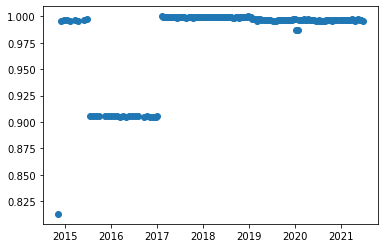

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(gdf.startTime,gdf.intersect)
# plt.ylim(0.99,1.01)

In [16]:
slcs = gdf[(gdf.intersect>0.99) & (gdf.startTime>=min_date)].copy().reset_index()
print(f'Removed {gdf.shape[0] - slcs.shape[0]} of {gdf.shape[0]} SLCs')

Removed 42 of 170 SLCs


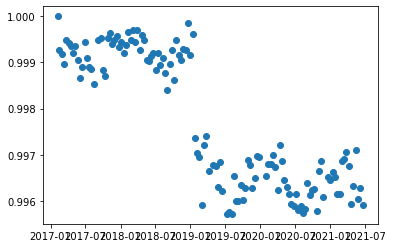

In [17]:
plt.scatter(slcs.startTime,slcs.intersect)

In [28]:
reference = slcs.fileName[0][:-4]
pairs = {}
names = slcs.fileName.str[:-4]
length = names.shape[0]

for i,reference in enumerate(names):
    secondary = []
    for j in [1,2,3]:
        index = i+j
        if index < length:
            secondary.append(names[index])
    if secondary != []:
        pairs[reference] = secondary

print(f'This includes {(len(pairs)-1)*3} interferograms')

This includes 378 interferograms


Enter Hyp3 credentials

In [19]:
hyp3 = sdk.HyP3(prompt=True)
my_info = hyp3.my_info()
print(f"Remaining Quota: {my_info['quota']['remaining']}")

NASA Earthdata Login username:  forrestfwilliams
NASA Earthdata Login password:  ····················


Remaining Quota: 2241


Create download list

In [ ]:
# # Project name
# # project_name = 'ifg_a_p81_f1048_20x4'
# project_name = 'p81f1048_10x2_2'

# # Set date bounds
# start_date = datetime.datetime(2017, 12, 31)
# end_date = datetime.datetime(2021, 12, 31)

# # Read in 
# df = pd.read_csv('slcs_asc_path81_frame1048.csv',usecols=['Granule Name', 'Acquisition Date'])

# # Convert and limit by date
# df['Acquisition Date'] = pd.to_datetime(df['Acquisition Date'], format='%Y-%m-%dT%H:%M:%S')
# df = df.loc[(df['Acquisition Date']>=start_date) & (df['Acquisition Date']<=end_date)]
# df = df.sort_values('Acquisition Date')

# granules = list(df['Granule Name'])
# print(f'Will create interferograms for {len(granules)} SLCs')

Request Ifg generation

In [20]:
project_name = 'asc_lower'

insar_jobs = sdk.Batch()
first = True

options = {'name':project_name,'looks':'10x2', 'include_wrapped_phase':False, 'apply_water_mask':True}
initial_options = dict(options)
initial_options.update({'include_inc_map':True,'include_dem':True,'include_look_vectors':True})

In [197]:
for reference in tqdm(pairs):
    for secondary in pairs[reference]:
        if first:
            insar_jobs += hyp3.submit_insar_job(reference, secondary, **initial_options)
            first = False
        else:
            insar_jobs += hyp3.submit_insar_job(reference, secondary, **options)

  0%|          | 0/127 [00:00<?, ?it/s]

Check progress and download

In [22]:
batch = hyp3.find_jobs(name=project_name)

if batch.complete():
    #filter to only succeeded jobs
    succeeded_jobs = batch.filter_jobs(succeeded=True, running=False, failed=False)
    
    complete = 0
    #download files if not downloaded already
    for job in succeeded_jobs.jobs:
        filename = job.to_dict()['files'][0]['filename']
        location = os.path.join(project_name,filename)
        if not os.path.exists(location):
            job.download_files(location=project_name,create=True)
        else:
            complete += 1

    print(f'{complete} files already downloaded!')

else:
    #to get updated information
    batch = hyp3.refresh(batch)
    #or to wait until completion and get updated information (which will take a fair bit)
    batch = hyp3.watch(batch)

378 files already downloaded!


Unzip files and clip to same extent

In [34]:
cd I:\hyp3_downloads

I:\hyp3_downloads


In [ ]:
#filter to only succeeded jobs
succeeded_jobs = batch.filter_jobs(succeeded=True, running=False, failed=False)

In [36]:
project_name = 'asc_upper'

zips = glob.glob(os.path.join(project_name,'*.zip'))
unws = [[x,f'{os.path.join(x.split(".")[0],os.path.basename(x).split(".")[0])}_unw_phase.tif'] for x in zips]

zips = [x[0] for x in unws if not os.path.exists(x[1])]
folders = [x.split('.')[0] for x in zips]

bad_files=[]

for zip_file, folder in tqdm(zip(zips, folders), total=len(zips)):
    try:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(project_name)
    except BadZipFile:
        bad_files.append(os.path.basename(zip_file))

if len(bad_files) > 0:
    print(f'These files were invalid zips:\n{bad_files}')

  0%|          | 0/381 [00:00<?, ?it/s]

In [39]:
folders = glob.glob(os.path.join(project_name,'S1*'))
all_images = []
for suffix in ['dem','inc_map','water_map','unw_phase','corr']:
    all_images += [os.path.join(x,f'{os.path.basename(x)}_{suffix}.tif') for x in folders]

exists = [x for x in all_images if os.path.exists(x)]
to_clip = [x for x in exists if not os.path.exists(f'{x[:-4]}_clip.tif')]
len(to_clip)

770

In [48]:
hyp3lib.cutGeotiffs.cutFiles(to_clip)

Clipping coordinates: (266020.0, 5753820.0, 548860.0, 5551620.0)
Found overlap size of 7071x5055
Pixsize : x = 40.0 y = -40.0
    clipping file asc_upper\S1AB_20170209T070658_20170215T070616_VVP006_INT40_G_weF_8864\S1AB_20170209T070658_20170215T070616_VVP006_INT40_G_weF_8864_dem.tif to create file asc_upper\S1AB_20170209T070658_20170215T070616_VVP006_INT40_G_weF_8864\S1AB_20170209T070658_20170215T070616_VVP006_INT40_G_weF_8864_dem_clip.tif
    clipping file asc_upper\S1AB_20170209T070658_20170215T070616_VVP006_INT40_G_weF_2157\S1AB_20170209T070658_20170215T070616_VVP006_INT40_G_weF_2157_dem.tif to create file asc_upper\S1AB_20170209T070658_20170215T070616_VVP006_INT40_G_weF_2157\S1AB_20170209T070658_20170215T070616_VVP006_INT40_G_weF_2157_dem_clip.tif
    clipping file asc_upper\S1AB_20170209T070658_20170215T070616_VVP006_INT40_G_weF_01BF\S1AB_20170209T070658_20170215T070616_VVP006_INT40_G_weF_01BF_dem.tif to create file asc_upper\S1AB_20170209T070658_20170215T070616_VVP006_INT40_G_weF

Done!